In [1]:
# 导入常用库
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from pandas import to_datetime
import math, time
import itertools
from sklearn.preprocessing import MinMaxScaler
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable

读入ETFs数据，把时间作为index，只留下开高低收四个变量用于后续

In [2]:
df_aaxj = pd.read_csv('D:/PycharmProjects/deep_learn/nlp/1-lstm/exp/data_stock/ETFs/aaxj.us.txt',index_col='Date')
df_aaxj

,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
2008-08-15,44.886,44.886,44.886,44.886,112,0
2008-08-18,44.564,44.564,43.875,43.875,28497,0
2008-08-19,43.283,43.283,43.283,43.283,112,0
2008-08-20,43.918,43.918,43.892,43.892,4468,0
2008-08-22,44.097,44.097,44.017,44.071,4006,0
...,...,...,...,...,...,...
2017-11-06,75.900,76.530,75.890,76.530,1313730,0
2017-11-07,76.490,76.580,76.090,76.185,1627277,0
2017-11-08,76.370,76.590,76.290,76.570,681128,0


只留2010-10-11: 2017-10-11的数据，因为此时索引不是01234，所以截取形式如下

In [3]:
df_main = df_aaxj['2010-10-11':'2017-10-11']
df_main

,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
2010-10-11,55.971,56.052,55.863,56.052,268544,0
2010-10-12,55.676,55.792,55.362,55.667,817951,0
2010-10-13,56.472,56.867,56.401,56.569,999413,0
2010-10-14,56.733,56.742,56.293,56.579,661897,0
2010-10-15,56.893,56.893,56.194,56.552,245001,0
...,...,...,...,...,...,...
2017-10-05,73.500,74.030,73.500,73.970,2134323,0
2017-10-06,73.470,73.650,73.220,73.579,2092100,0
2017-10-09,73.500,73.795,73.480,73.770,879600,0


只留开高低收四个关键字

In [4]:
df_main = df_main[['Open', 'High', 'Low', 'Close']]
df_main

,Open,High,Low,Close
Date,,,,
2010-10-11,55.971,56.052,55.863,56.052
2010-10-12,55.676,55.792,55.362,55.667
2010-10-13,56.472,56.867,56.401,56.569
2010-10-14,56.733,56.742,56.293,56.579
2010-10-15,56.893,56.893,56.194,56.552
...,...,...,...,...
2017-10-05,73.500,74.030,73.500,73.970
2017-10-06,73.470,73.650,73.220,73.579
2017-10-09,73.500,73.795,73.480,73.770


先处理空值
进行归一化数据处理 防止爆炸

In [5]:
df_main.describe()

,Open,High,Low,Close
count,1763.000000,1763.000000,1763.000000,1763.000000
mean,55.781820,56.025560,55.509895,55.786973
std,5.707644,5.663721,5.753059,5.714099
min,40.671000,41.885000,40.074000,41.061000
25%,52.124500,52.322000,51.878500,52.146000
50%,55.504000,55.757000,55.276000,55.496000
75%,58.666500,58.837500,58.455500,58.695000
max,74.290000,74.645000,74.210000,74.610000


In [6]:
df_main.isna

<bound method DataFrame.isna of               Open    High     Low   Close
Date                                      
2010-10-11  55.971  56.052  55.863  56.052
2010-10-12  55.676  55.792  55.362  55.667
2010-10-13  56.472  56.867  56.401  56.569
2010-10-14  56.733  56.742  56.293  56.579
2010-10-15  56.893  56.893  56.194  56.552
...            ...     ...     ...     ...
2017-10-05  73.500  74.030  73.500  73.970
2017-10-06  73.470  73.650  73.220  73.579
2017-10-09  73.500  73.795  73.480  73.770
2017-10-10  74.150  74.490  74.150  74.480
2017-10-11  74.290  74.645  74.210  74.610

[1763 rows x 4 columns]>

In [7]:
df_main = df_main.fillna(method='ffill')
df_main.describe()

,Open,High,Low,Close
count,1763.000000,1763.000000,1763.000000,1763.000000
mean,55.781820,56.025560,55.509895,55.786973
std,5.707644,5.663721,5.753059,5.714099
min,40.671000,41.885000,40.074000,41.061000
25%,52.124500,52.322000,51.878500,52.146000
50%,55.504000,55.757000,55.276000,55.496000
75%,58.666500,58.837500,58.455500,58.695000
max,74.290000,74.645000,74.210000,74.610000


In [8]:
scaler = MinMaxScaler(feature_range=(-1, 1))

In [9]:
sel_col = ['Open', 'High', 'Low', 'Close']

In [10]:
for col in sel_col:
    df_main[col] = scaler.fit_transform(df_main[col].values.reshape(-1,1))

df_main

,Open,High,Low,Close
Date,,,,
2010-10-11,-0.089800,-0.135104,-0.074936,-0.106322
2010-10-12,-0.107350,-0.150977,-0.104289,-0.129274
2010-10-13,-0.059996,-0.085348,-0.043415,-0.075502
2010-10-14,-0.044469,-0.092979,-0.049742,-0.074905
2010-10-15,-0.034950,-0.083761,-0.055543,-0.076515
...,...,...,...,...
2017-10-05,0.953003,0.962454,0.958402,0.961847
2017-10-06,0.951218,0.939255,0.941997,0.938538
2017-10-09,0.953003,0.948107,0.957230,0.949924


创造需要预测的序列。因为我们要预测下一个时间的收盘价，所以把close向上shift1个单位：

In [11]:
df_main['target'] = df_main['Close'].shift(-1)
df_main.dropna()
df_main = df_main.astype(np.float32)

接下来要根据LSTM需要的数据格式来创造数据集。Lstm需要的输入是一个3D array[x,y,z],其中x是样本数，y是seq length，即需要看多少天的数据，z是特征数。x=length, y=batch_size, z=feature_size

In [12]:
def create_seq_data(data_raw, seq):
    # data_raw完整数据，seq为一句长度
    # 例如data_raw.length==100, seq=10
    # [0:10] [1:11] [2:12]......[90:100]
    data_feat, data_target = [], []

    for index in range(len(data_raw) - seq):
        # 构建特征集
        data_feat.append(data_raw[['Open', 'High', 'Low', 'Close']][index: index+seq].values)
        data_target.append(data_raw['target'][index:index+seq])
    data_feat = np.array(data_feat)
    data_target = np.array(data_target)

    return data_feat, data_target

样本数是1808，我们所设定的每个时间区间是20天，通过高开低收4个来预测，所以datafeat的维度是(1808,20,4)，对应的data_target的维度是(1808,20,1)，1808和20和feat一样，但是因为预测只有一个数值即下一天的收盘价，所以维度为1.

然后开始划分训练和测试集，这里按8：2分了下：

In [13]:
def train_test(data_feat, data_target, test_set_size, seq):
    train_size = data_feat.shape[0]-(test_set_size)
    trainX = torch.from_numpy(data_feat[:train_size].reshape(-1, seq, 4)).type(torch.Tensor)
    testX =torch.from_numpy(data_feat[train_size:].reshape(-1,seq,4)).type(torch.Tensor)
    trainY = torch.from_numpy(data_target[:train_size].reshape(-1, seq, 1)).type(torch.Tensor)
    testY = torch.from_numpy(data_target[train_size:].reshape(-1, seq, 1)).type(torch.Tensor)

    return trainX, trainY, testX, testY



In [14]:
data_raw=df_main

In [15]:
seq = 20
test_set_size = int(np.round(0.2*data_raw.shape[0]))

feat, target = create_seq_data(data_raw, seq)
trainX, trainY, testX, testY = train_test(feat, target, test_set_size, seq)

In [16]:
print('x_train.shape = ',trainX.shape)
print('y_train.shape = ',trainY.shape)
print('x_test.shape = ',testX.shape)
print('y_test.shape = ',testY.shape)

x_train.shape =  torch.Size([1390, 20, 4])
y_train.shape =  torch.Size([1390, 20, 1])
x_test.shape =  torch.Size([353, 20, 4])
y_test.shape =  torch.Size([353, 20, 1])


In [17]:
n_steps = seq
batch_size = 1442
num_epochs = 100
train = torch.utils.data.TensorDataset(trainX,trainY)
test = torch.utils.data.TensorDataset(testX,testY)
train_loadr = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size,shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size,shuffle=False)

建立LSTM model
LSTM的参数主要有input_dim,hidden_dim,num_layers,output_dim.

其中input_dim可以看成是输入的特征数，在我们这里就是4；hidden_dim这里我们选了32，num_layers是有几层的lstm层，output_dim是最后输出几维，由于最后我们的target只是一维所以output_dim=1.

In [18]:
input_dim = 4
hidden_dim = 32
num_layers = 2
output_dim = 1

In [19]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # 隐藏层维度
        self.hidden_dim = hidden_dim

        # 隐lstm层数
        self.num_layers = num_layers
        # 构建LSTM
        # batch_size=True
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # 输出层、全连接层
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # 初始化隐层节点状态
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # 初始化细胞节点状态
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # one time step
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        out = self.fc(out)
        return out

In [20]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

In [21]:
model

LSTM(
  (lstm): LSTM(4, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

定义loss function和优化函数，因为预测数值问题，所以运用了MSE来衡量差值，adam用于优化，可以自适应率寻找到一个比较好的优化路径。

In [22]:
loss_fn = torch.nn.MSELoss(size_average=True)
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

C:\Users\86176\AppData\Roaming\Python\Python37\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


### 训练模型

In [23]:
for x, y in enumerate(train_loadr):
    print(x,y)

0 [tensor([[[-0.0898, -0.1351, -0.0749, -0.1063],
         [-0.1074, -0.1510, -0.1043, -0.1293],
         [-0.0600, -0.0853, -0.0434, -0.0755],
         ...,
         [-0.0126, -0.0504, -0.0266, -0.0236],
         [ 0.0466,  0.0250,  0.0531,  0.0458],
         [ 0.0642,  0.0349,  0.0768,  0.0517]],

        [[-0.1074, -0.1510, -0.1043, -0.1293],
         [-0.0600, -0.0853, -0.0434, -0.0755],
         [-0.0445, -0.0930, -0.0497, -0.0749],
         ...,
         [ 0.0466,  0.0250,  0.0531,  0.0458],
         [ 0.0642,  0.0349,  0.0768,  0.0517],
         [ 0.0684,  0.0234,  0.0751,  0.0484]],

        [[-0.0600, -0.0853, -0.0434, -0.0755],
         [-0.0445, -0.0930, -0.0497, -0.0749],
         [-0.0350, -0.0838, -0.0555, -0.0765],
         ...,
         [ 0.0642,  0.0349,  0.0768,  0.0517],
         [ 0.0684,  0.0234,  0.0751,  0.0484],
         [ 0.0754,  0.0399,  0.0463,  0.0170]],

        ...,

        [[-0.2199, -0.2383, -0.1967, -0.2135],
         [-0.1733, -0.2046, -0.1560, -0.17

In [24]:

hist = np.zeros(num_epochs)
seq_dim = seq
plt_loss = []
for t in range(num_epochs):
    # 初始化隐藏状态
    # Don't do this if you want your LSTM to be stateful
    # model.hidden = model.init_hidden()

    # 前向传播
    y_train_pred = model(trainX)
    loss = loss_fn(y_train_pred, trainY)
    if t%10==0 and t!=0:
        print('Epoch ', t, "MSE: ", loss.item())
    hist[t] = loss.item()
    plt_loss.append(loss.item())
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

Epoch  10 MSE:  0.031211448833346367
Epoch  20 MSE:  0.01440457347780466
Epoch  30 MSE:  0.00746068125590682
Epoch  40 MSE:  0.004427543841302395
Epoch  50 MSE:  0.0034078056924045086
Epoch  60 MSE:  0.0027440786361694336
Epoch  70 MSE:  0.002327204681932926
Epoch  80 MSE:  0.0020735778380185366
Epoch  90 MSE:  0.001914164749905467


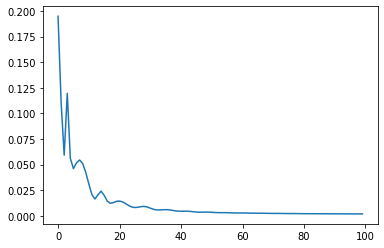

In [25]:
plt.plot(range(num_epochs),plt_loss)

In [27]:
y_test_pred = model(testX)

In [35]:
y_test_pred.size(0) ,y_test_pred.size(1), y_test_pred.size(2)#[len, seq, 1]

(353, 20, 1)

In [29]:
y_train_pred.detach().numpy()[:,-1,0]

array([ 0.05483837,  0.05599086,  0.04284535, ..., -0.4501235 ,
       -0.42848188, -0.4281816 ], dtype=float32)

In [37]:
# 转换一下
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy()[:,-1,0].reshape(-1,1))


AttributeError: 'numpy.ndarray' object has no attribute 'detach'

In [38]:
y_train = scaler.inverse_transform(trainY.detach().numpy()[:,-1,0].reshape(-1, 1))

In [39]:
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy()[:,-1,0].reshape(-1,1))
test = scaler.inverse_transform(testY.detach().numpy()[:,-1,0].reshape(-1, 1))

In [40]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train, y_train_pred))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(test, y_test_pred))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.69 RMSE
Test Score: 0.95 RMSE
